In [2]:
"""
Project for Olin College, Data Science, Spring 2017.

Data from:
https://www.nass.usda.gov/Surveys/Guide_to_NASS_Surveys/Bee_and_Honey/
http://usda.mannlib.cornell.edu/MannUsda/viewDocumentInfo.do?documentID=1191


unzip the csv zip files with

$  for VARIABLE in 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016; 
$  do   unzip *$VARIABLE.zip -d $VARIABLE; 
$  done

or pull them from my git.
"""

import numpy as np
import pandas
import os
import string
import itertools
import matplotlib.pyplot as plt
import thinkstats2

# Loading and Cleaning Data

The data given by the USDA is collected in a number of poorly standardized set of CSV files. In this section, we create a standard scheme for storing the CSV files, and fix some small irregularities in naming conventions. 

First, we fixed the problem created by the USDA state name formatting change. We settled on only using their official abbreviations.

In [3]:
# USDA format changed around 2010. This maps from state names to their abbreviations.
abbrev_dict = { 
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'Other States 5/ 6/': 'Sts',
    'United States 6/ 7/': 'US'
}

# Used for pyplot labeling purposes
index_to_name = {
    0: "Year",
    1: "Colony count (1000s)",
    2: "Yield (lbs per colony)",
    3: "Production (1000 lbs)",
    4: "Stocks (1000 lbs)",
    5: "Price (cents/lb)",
    6: "Total value ($1000s)",
    -1: "Colony count (% 2002)",
    -2: "Yield (% 2002)",
    -3: "Production (% 2002)",
    -4: "Stocks (% 2002)",
    -5: "Price (% 2002)",
    -6: "Total value (% 2002)"
}

Next, we need to load all of the csv files based on their names.

In [4]:
def get_all_csvs(csv_years=[2002+i for i in range(15)], csv_path="data/csvs/"):
    '''
    Returns a list of all csv files in the (hard-coded) year-directory combinations.
    '''
    all_csvs = []
    for i in csv_years:
        this_path = csv_path + str(i) + "/"
        these_files = os.listdir(this_path)
        these_csvs = [(this_path + i) for i in these_files if i[-4:] == ".csv"]
        all_csvs.extend(these_csvs)
    return all_csvs

Each csv (containing the data for one year) becomes its own object, with a separate data frame. This makes it easier to manipulate elsewhere. Some of the cleaning in these is hard-coded because of errors that had to be fixed inside the columns, like typos.

In [5]:
class Csv_obj(object):
    def __init__(self, filename):
        self.name = filename
        year_start = filename.find("20")
        self.year = int(filename[year_start:year_start+4])
        self.data_type = filename[(filename.find("_") + 1) : (filename.find(".csv"))]
        # 001: honey type/color/grade to quantity, price for that year
        #   color class : price (cents per pound), 
        #   Co-op/private : Retail : All
        # 002: State, number of colonies (1000s), 
        #   Yield (per colony), Yield (total, 1000 lbs), stocks (1klbs),
        #   Average price per pound (cents),
        #   total value of production.
        # 003: 
        temp_df = sanitize_then_load_csv(filename)
        self.df = self.clean_df(temp_df)

    def __str__(self):
        return str(self.year) + ":" + self.data_type
    
    def clean_df(self, target, target_dtype="002"):
        if self.data_type[-3:] == target_dtype:
            col_names = ["state","colonies","yld","production","stocks","prices","totalval"]
                        # abbr,   1000s      lbs/col  1000 lbs    1000 lbs  cents    $1000s   
            final = target.drop(target.columns[0],1).drop(target.columns[1],1).dropna()
            final.columns = col_names
            final = final[final.state != "State"]
            return final
        else:
            return target # todo: clean; right now 002 is all we care about though.
    
    def isnull(self):
        if self.df is None:
            return True
        else:
            return False

In [6]:
def sanitize_then_load_csv(filename, min_col_length=9, max_col_length = None):
    """
    Gets around the metadata-y columns by scanning for the length of .split(',').
    TODO: make it ignore the "format"/grammatical commas which occur within a single entry in the csv.
    """
    f = open(filename)
    lines_to_skip = []
    for i, line in enumerate(f.readlines()):
        l_split = line.split(',') # will also split internal commas in strings. todo: fix. low priority.
        if len(l_split) < min_col_length:
            lines_to_skip.append(i)
        elif max_col_length != None:
            if len(l_split) > max_col_length:
                lines_to_skip.append(i)
    try:
        df = pandas.read_csv(filename, skiprows = lines_to_skip)
    except Exception as err:
        print "Cannot read: ", filename, "\t ", str(err)[str(err).find("Expected"):]
        df = None
    return df

Since we want to explore the change in the data over time, it's best to be able to access data by the state name. This dictionary allows you to get all data for a single state, instead of having to repeatedly access different years.

In [7]:
def generate_state_to_vals_dict():
    """
    Loads all CSVs into Csv_obj with dataframes, and parses into a dictionary value.
    Returns (list of all csv_objs, state_to_values_dict)
    """
    all_csvs = get_all_csvs()
    csv_objs = [Csv_obj(i) for i in all_csvs]
    relevants = [i for i in csv_objs if i.data_type[-3:] == "002"]
    state_to_vals_dict = {}
    for i in relevants:
        yr = i.year
        df = i.df
        for index, row in df.iterrows():
            if row.state in abbrev_dict:
                this_state = abbrev_dict[row.state]
            else:
                if row.state[:3] in ["Sts"," St"]:
                    this_state = "Sts"
                elif row.state[:2] == "US":
                    this_state = "US"
                else:
                    this_state = row.state
            this_tup = (yr, row.colonies, row.yld, row.production, row.stocks, row.prices, row.totalval)
            if this_state in state_to_vals_dict:
                state_to_vals_dict[this_state].append(this_tup)
            else:
                state_to_vals_dict[this_state] = [this_tup]
    for i in state_to_vals_dict.keys():
        state_to_vals_dict[i] = sorted(state_to_vals_dict[i])
    return csv_objs, state_to_vals_dict

# Exploring patterns in Honey Production

These are the functions which are used to find correlations between different parts of the dataset, trends in certain variables, and other patters.

In [25]:
def plot_vals(state_to_vals_dict, states=["US","CA","AZ","Sts","ND"],target_x = 0, target_y=1, as_pct=True):
    '''
    plots the target_x against target_y for [states]
    as_pct = plots yvalues as percent of first value, in 2002.
    Default: colony count vs year, as percent of 2002.
    
    [year, colonies (1k), yield (lbs/col),
    production (1k lbs), stocks (1k lbs), 
    price (cents), totalval ($1k)]
    '''
    for state in states:
        data = state_to_vals_dict[state]
        xs = [i[target_x] for i in data]
        ys = [i[target_y] for i in data]
        if as_pct:
            ys = [float(i)/float(ys[0]) for i in ys]
        plt.plot(xs, ys, label=state)
    if as_pct:
        xname = index_to_name[target_x * -1]
        yname = index_to_name[target_y * -1]
    else:
        xname = index_to_name[target_x]
        yname = index_to_name[target_y]
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.legend(loc=0)
    plt.show()

def scatter_all(state_to_vals_dict, target_x=2, target_y=5, as_pct_x=False, as_pct_y=False):
    '''
    scatters the x vs the y for all states, years.
    Default: honey price vs. honey production per colony.
    '''
    tups = []
    for state in state_to_vals_dict.keys():
        data = state_to_vals_dict[state]
        xs = [i[target_x] for i in data]
        ys = [i[target_y] for i in data]
        if as_pct_x:
            xs = [float(i)/float(xs[0]) for i in xs]
        if as_pct_y:
            ys = [float(i)/float(ys[0]) for i in ys]
        tups.extend(zip(xs, ys))            
    if as_pct_x:
        xname = index_to_name[target_x * -1]
    else:
        xname = index_to_name[target_x]
    if as_pct_y:
        yname = index_to_name[target_y * -1]
    else:
        yname = index_to_name[target_y]
    xvals, yvals = zip(*tups) 
    plt.scatter(xvals, yvals)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.title("Figure 1: Price vs. Yield of Honey (in all states)")
    plt.show()
        
def scatter_hilo(state_to_vals_dict, target_x=2, target_y=5, as_pct_x=False, as_pct_y=False):
    '''
    scatters the x vs the y for all states, years.
    colors high and low-producing states differently.
    Default: honey price vs. honey production per colony.
    '''
    tups_high = []
    tups_low = []
    prod_means = []
    
    for state in state_to_vals_dict.keys():
        prods = [i[3] for i in state_to_vals_dict[state]]
        prods_np = np.array(prods).astype(np.float)
        mean = np.mean(prods_np)
        prod_means.append(mean)
        
    m = np.mean(prod_means)
    
    for state in state_to_vals_dict.keys():
        data = state_to_vals_dict[state]
        mean_prod = np.mean([int(i[3]) for i in data])
        
        xs = [float(i[target_x]) for i in data]
        ys = [float(i[target_y]) for i in data]
        if as_pct_x:
            xs = [float(i)/float(xs[0]) for i in xs]
        if as_pct_y:
            ys = [float(i)/float(ys[0]) for i in ys]
        
        if mean_prod > m:
            tups_high.extend(zip(xs, ys))
        else:
            tups_low.extend(zip(xs, ys))
            
    if as_pct_x:
        xname = index_to_name[target_x * -1]
    else:
        xname = index_to_name[target_x]
    if as_pct_y:
        yname = index_to_name[target_y * -1]
    else:
        yname = index_to_name[target_y]
    
    xvals_high, yvals_high = zip(*tups_high) 
    xvals_low, yvals_low = zip(*tups_low)
    print "high:\t", thinkstats2.Corr(xvals_high, yvals_high)
    print "low:\t", thinkstats2.Corr(xvals_low, yvals_low)
    plt.scatter(xvals_low, yvals_low, c='r', s=14, linewidths=0)
    plt.scatter(xvals_high, yvals_high, c='b', s=20, linewidths=0)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.title("Figure 2: Price vs. Yield of Honey (by production)")
    plt.legend(['Low Production States','High Production States'])
    plt.show()

    
def corr_one(state_to_vals_dict, target_x=2, target_y=5):
    '''
    Gets the correlation between target_x and target_y.
    Default: honey price vs. honey production per colony.
    '''
    tups = []
    for state in state_to_vals_dict.keys():
        data = state_to_vals_dict[state]
        xs = [float(i[target_x]) for i in data]
        ys = [float(i[target_y]) for i in data]
        tups.extend(zip(xs, ys))  
    xvals, yvals = zip(*tups) 
    return thinkstats2.Corr(xvals, yvals)

def corr_all(state_to_vals_dict):
    '''
    Checks all combinations of x and y for correlation.
    '''
    all_corrs = []
    for x in range(7):
        for y in range(x+1,7):
            this_corr = corr_one(state_to_vals_dict, target_x=x, target_y=y)
            all_corrs.append((this_corr,index_to_name[x],index_to_name[y]))
    return sorted(all_corrs,reverse=True)

In [9]:
def production_to_next_stock_correlation(state_to_vals_dict):
    stock_production_correlation = []
    plottable_tups = []
    for state in state_to_vals_dict.keys():
        data = state_to_vals_dict[state]
        #Checking correlation between production one year and stocks next year
        production = [int(i[3]) for i in data]
        stocks = [float(i[4]) for i in data]
        production = production[:-1]
        stocks = stocks[1:]
        corr = thinkstats2.Corr(stocks, production)
        stock_production_correlation.append((state, corr))
        plottable_tups.extend(zip(stocks, production))
    stock_production_correlation.sort(reverse = True, key = lambda item: item[1])
#     for state, correlation in stock_production_correlation:
#         print(state + ': ' + str(correlation))
    return stock_production_correlation, plottable_tups

def compare_states(state_to_vals_dict, state1, state2, param_number):
    data1 = state_to_vals_dict[state1]
    data2 = state_to_vals_dict[state2]
    state1 = [float(i[param_number]) for i in data1]
    state2 = [float(i[param_number]) for i in data2]
    if len(state1) == len(state2):
        return thinkstats2.Corr(state1, state2)
    else:
        return -1

def correlate_states(state_to_vals_dict, pn=2, topn=6):
    correlations = []
    i = 1
    for pair in itertools.combinations(state_to_vals_dict.keys(),2):
        i += 1
        s1 = pair[0]
        s2 = pair[1]
        correlations.append((s1, s2, compare_states(state_to_vals_dict, s1, s2, param_number=pn)))
    correlations.sort(reverse=True, key = lambda item: item[2])
    corr_dict = {}
    for i in correlations:
        s1 = i[0]
        s2 = i[1]
        c = i[2]
        if s1 in ["US", "Sts"] or s2 in ["US","Sts"]:
            continue
        if s1 in corr_dict:
            corr_dict[s1].append((c,s2))
        else:
            corr_dict[s1] = [(c,s2)]
        if s2 in corr_dict:
            corr_dict[s2].append((c,s1))
        else:
            corr_dict[s2] = [(c, s1)]
    corr_list = [(np.mean([t[0] for t in corr_dict[k][:topn]]),k) for k in corr_dict.keys()]
    corr_list.sort(reverse=True)
    for state in corr_list:
        print state[1], ":"
        for i in corr_dict[state[1]][:topn]:
            print "\t", i

In [10]:
# preamble to get the dictionary mapping states to values.
_, stv = generate_state_to_vals_dict()

Cannot read:  data/csvs/2008/hony_all.csv 	  Expected 9 fields in line 155, saw 11

Cannot read:  data/csvs/2009/hony_all.csv 	  Expected 9 fields in line 155, saw 11

Cannot read:  data/csvs/2010/hony_all.csv 	  Expected 9 fields in line 155, saw 11

Cannot read:  data/csvs/2011/hony_all_tables.csv 	  Expected 9 fields in line 153, saw 11

Cannot read:  data/csvs/2012/hony_all_tables.csv 	  Expected 9 fields in line 152, saw 10

Cannot read:  data/csvs/2013/hony_all_tables.csv 	  Expected 9 fields in line 152, saw 10

Cannot read:  data/csvs/2014/hony_all_tables.csv 	  Expected 9 fields in line 151, saw 10

Cannot read:  data/csvs/2015/hony_all_tables.csv 	  Expected 9 fields in line 151, saw 10

Cannot read:  data/csvs/2016/hony_all_tables.csv 	  Expected 9 fields in line 166, saw 10

Cannot read:  data/csvs/2016/hony_p00a_t005.csv 	  e


In [27]:
# Inter-state correlation:
correlate_states(stv, pn = 2, topn=8)

AL :
	(0.92444604969462518, 'OR')
	(0.87588413100069329, 'WA')
	(0.82724472737566823, 'UT')
	(0.8135811878267678, 'ID')
	(0.80695899654219716, 'FL')
	(0.80640036979899077, 'WI')
	(0.78199010266682489, 'MN')
	(0.75796177376903417, 'NY')
OR :
	(0.92444604969462518, 'AL')
	(0.85292707841749649, 'WA')
	(0.77753287046756103, 'WI')
	(0.77686711605189285, 'MN')
	(0.74863652443974515, 'FL')
	(0.74768960229258319, 'ID')
	(0.74225351628193503, 'UT')
	(0.71700793539490415, 'WY')
WA :
	(0.87588413100069329, 'AL')
	(0.85292707841749649, 'OR')
	(0.79433260746673051, 'ID')
	(0.7681144220059869, 'UT')
	(0.76688559722463856, 'CO')
	(0.76487059017290771, 'FL')
	(0.73411523480078411, 'MN')
	(0.6972119733992469, 'WI')
WI :
	(0.80640036979899077, 'AL')
	(0.80032870936843714, 'FL')
	(0.77753287046756103, 'OR')
	(0.76785992100233469, 'IA')
	(0.7661231681253855, 'MN')
	(0.73331901197507132, 'IL')
	(0.6984878750463116, 'UT')
	(0.6972119733992469, 'WA')
FL :
	(0.80695899654219716, 'AL')
	(0.80032870936843714, '

In [28]:
# Correlation betwewen all parameters:
corr_all(stv)


[(0.99076004812331875, 'Colony count (1000s)', 'Production (1000 lbs)'),
 (0.97057792691681499, 'Production (1000 lbs)', 'Stocks (1000 lbs)'),
 (0.95567981257964019, 'Colony count (1000s)', 'Total value ($1000s)'),
 (0.94799959652632859, 'Colony count (1000s)', 'Stocks (1000 lbs)'),
 (0.93177815055657132, 'Production (1000 lbs)', 'Total value ($1000s)'),
 (0.84145313764376728, 'Stocks (1000 lbs)', 'Total value ($1000s)'),
 (0.692100969187879, 'Year', 'Price (cents/lb)'),
 (0.14995041663077072, 'Yield (lbs per colony)', 'Production (1000 lbs)'),
 (0.14819878941664169, 'Yield (lbs per colony)', 'Stocks (1000 lbs)'),
 (0.10560255418998386, 'Yield (lbs per colony)', 'Total value ($1000s)'),
 (0.10153966975193587, 'Colony count (1000s)', 'Yield (lbs per colony)'),
 (0.081694920900981724, 'Year', 'Total value ($1000s)'),
 (0.012909067882169367, 'Year', 'Colony count (1000s)'),
 (-0.013858931107513345, 'Year', 'Production (1000 lbs)'),
 (-0.047063856821921261, 'Year', 'Stocks (1000 lbs)'),
 (

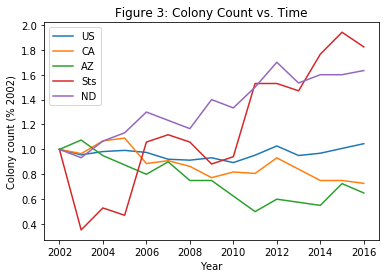

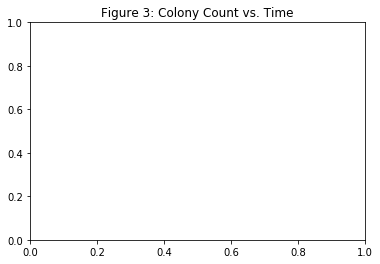

In [31]:
# Graph of colony count over years
plot_vals(stv)
plt.title("Figure 3: Colony Count vs. Time")
plt.show()

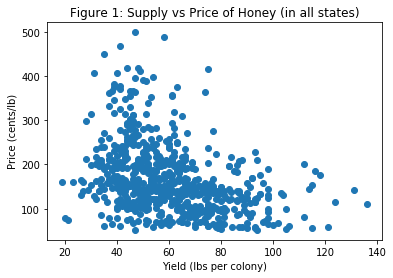

In [20]:
# Scatter of price and production data
scatter_all(stv)

high:	-0.43375160972
low:	-0.319981936581


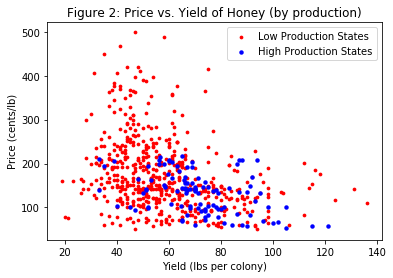

In [26]:
# Scatter of price and production, categorized by high/low-production states
scatter_hilo(stv)


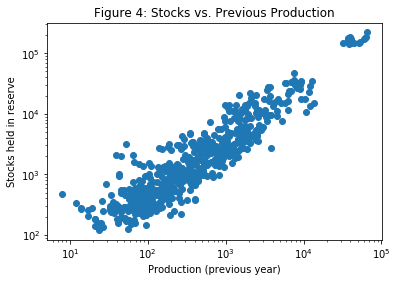

In [32]:
# Time correlation for production to the next year's reserve stocks
spc, s = production_to_next_stock_correlation(stv)
x, y = zip(*s)
plt.scatter(x, y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Production (previous year)")
plt.ylabel("Stocks held in reserve")
plt.title("Figure 4: Stocks vs. Previous Production")
plt.show()